In [32]:
import jax
from matplotlib import pyplot as plt
from jax import numpy as jnp
key = jax.random.key(42)

In [154]:
@jax.jit
def NashMax(z, U):
    return jnp.sum(jnp.log(z.T @ U))

@jax.jit
def ProjSimplex(x): #очень сильно накапливается ошибка
    N, = x.shape
    x_sort = jnp.sort(x, descending = True)
    cmsm = jnp.cumsum(x_sort) - jnp.arange(1,N+1) * x_sort
    M = jnp.max((cmsm <= 1.0).astype(int) * jnp.arange(1,N+1))  
    shift = x_sort[M-1] - (1 - cmsm[M-1]) / M
    return  jnp.maximum(x - shift, 0)

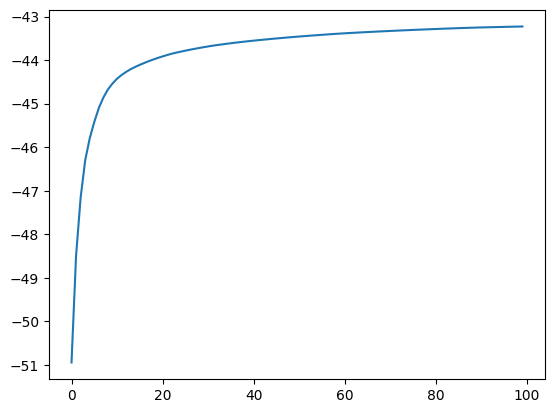

In [174]:
m, n = 50, 70
U = jax.random.randint(key,(m,n), 0, 2)
assert jnp.all(jnp.sum(U, axis = 0)), 'U содержит нулевой столбец'
z = jnp.ones((m,)) / m

N = 100
gamma = 0.001
res = []
for i in range(N):
    res.append(NashMax(z, U))
    grad = jax.grad(NashMax, 0)(z, U)
    z = ProjSimplex(z + gamma/jnp.sqrt(i+1) * grad)

plt.plot(range(len(res)), res)